In [1]:
import scanpy as sc
import sys
sys.path.append("../")
import trvaep
import numpy as np

## loading and preparing data 

In [2]:
adata = sc.read("../data/haber_count.h5ad", backup_url="shorturl.at/imuEP")
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']]
n_conditions = adata.obs["condition"].unique().shape[0]
condition_key = "condition"

In [3]:
adata_train = adata[~((adata.obs["cell_label"] == "TA")
                      & (adata.obs["condition"] == "Hpoly.Day10"))]

In [4]:
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)


         Falling back to preprocessing with `sc.pp.pca` and default params.


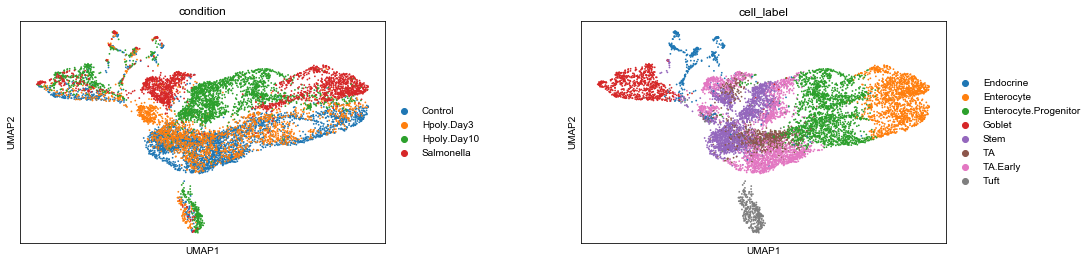

In [5]:
sc.pl.umap(adata_train, color=["condition", "cell_label"], wspace=.4)

## creating model object 

In [6]:
model = trvaep.CVAE(adata_train.n_vars, num_classes=n_conditions,
            output_activation="ReLU", encoder_layer_sizes=[64, 32], decoder_layer_sizes=[32, 64], use_mmd=True, beta=1)

### Make a trainer object 


In [ ]:
trainer = trvaep.Trainer(model, adata_train, condition_key=condition_key)

#### important: please consider using larger batch size (e.g. 1024, 2048) for datasets with more than two batches (i.e. conditions, studies) for better performance and avoid any computation error.

In [8]:
trainer.train_trvae(n_epochs=300, batch_size=512, early_patience=50)

Epoch 00/300 Batch 0000/15, Loss:  388.9540, rec_loss:  387.3120, KL_loss:    0.0021, MMD_loss:     1.6400
Epoch 00/300 Batch 0015/15, Loss:  233.0981, rec_loss:  231.4851, KL_loss:    0.0028, MMD_loss:     1.6102
Epoch 01/300 Batch 0000/15, Loss:  226.2108, rec_loss:  224.6947, KL_loss:    0.0029, MMD_loss:     1.5131
Epoch 01/300 Batch 0015/15, Loss:  184.3745, rec_loss:  183.0172, KL_loss:    0.0040, MMD_loss:     1.3533
Epoch 02/300 Batch 0000/15, Loss:  187.5044, rec_loss:  186.1422, KL_loss:    0.0040, MMD_loss:     1.3582
Epoch 02/300 Batch 0015/15, Loss:  160.1572, rec_loss:  158.7332, KL_loss:    0.0048, MMD_loss:     1.4192
Epoch 03/300 Batch 0000/15, Loss:  161.5090, rec_loss:  160.1668, KL_loss:    0.0049, MMD_loss:     1.3373
Epoch 03/300 Batch 0015/15, Loss:  149.5970, rec_loss:  148.3430, KL_loss:    0.0065, MMD_loss:     1.2475
Epoch 04/300 Batch 0000/15, Loss:  146.4888, rec_loss:  145.2492, KL_loss:    0.0065, MMD_loss:     1.2331
Epoch 04/300 Batch 0015/15, Loss:  13

## visualizing the MMD latent space

You can use MMD layer representation for batch-removal

`c` can be the batch or the condition that you want your data to be mapped on it.

... storing 'cell_label' as categorical
... storing 'condition' as categorical


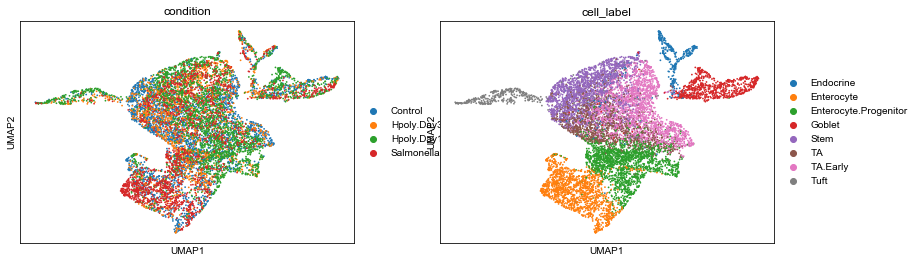

In [9]:
latent_y = model.get_y(
    adata.X, c=model.label_encoder.transform(np.tile(np.array("Control"), len(adata))))
adata_latent = sc.AnnData(latent_y)
adata_latent.obs["cell_label"] = adata.obs["cell_label"].tolist()
adata_latent.obs[condition_key] = adata.obs[condition_key].tolist()
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color=[condition_key, "cell_label"])

## Making prediction

... storing 'barcode' as categorical
... storing 'cell_label' as categorical
... storing 'condition' as categorical


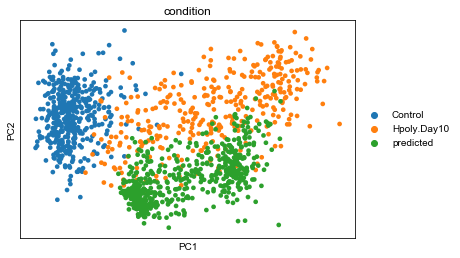

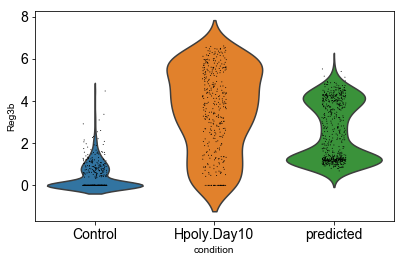

In [10]:
ground_truth = adata[((adata.obs["cell_label"] == "TA")
                      & (adata.obs["condition"].isin(["Hpoly.Day10", "Control"])))]
adata_source = adata[(adata.obs["cell_label"] == "Stem") &
                     (adata.obs["condition"] == "Hpoly.Day10")]
predicted_data = model.predict(x=adata_source.X, y=adata_source.obs["condition"].tolist(),
                               target="Hpoly.Day10")
adata_pred = sc.AnnData(predicted_data)
adata_pred.obs["condition"] = np.tile("predicted", len(adata_pred))
adata_pred.var_names = adata_source.var_names.tolist()
all_adata = ground_truth.concatenate(adata_pred)
sc.tl.pca(all_adata)
sc.pl.pca(all_adata, color=["condition"])
sc.pl.violin(all_adata, keys="Reg3b", groupby="condition")

### Get batch corrected data in output space for all data 

`target` can be the batch or the condition that you want your data to be mapped on it.

In [11]:
batch_removed = model.predict(x=adata.X, y=adata.obs[condition_key].tolist(),
                               target="Control")

In [12]:
corrected = sc.AnnData(batch_removed)
corrected.obs["cell_label"] = adata.obs["cell_label"].tolist()
corrected.obs[condition_key] = adata.obs[condition_key].tolist()

In [13]:
sc.pp.neighbors(corrected)
sc.tl.umap(corrected)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'cell_label' as categorical
... storing 'condition' as categorical


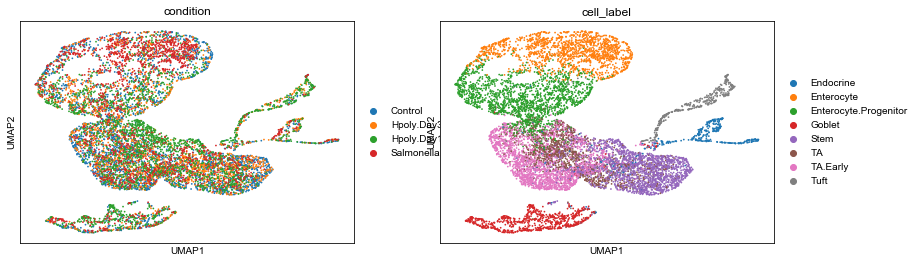

In [14]:
sc.pl.umap(corrected, color=[condition_key, "cell_label"])